Workflow

Preparing the data

Load the dataset.                     
The original dataset is too large and needs to be reduced. To reduce it, you can, for instance,
filter out items that have too many or too little tokens,
select items of a certain type: post, comments, or titles, or
or sub sample items randomly.
Build the vocabulary as the set of all unique tokens to construct the list of token indexes.
Filtering on token frequency is one way to reduce the overall size of the vocabulary.
Set a fixed sequence length and build sequences of token indexes from the corpus. (See for instance keras pad_sequences.)
Split the sequences into predictors and labels (keras.utils.to_categorical)
The model The data is now ready to be used to fit a neural network.

Define a simple sequential model with an embedding layer, LSTM(s), and a dense layer with softmax activation. Feel free to experiment with dropouts, different optimizers. You can use any type of neural net you want; for example, Keras, TensorFlow, PyTorch, and so on.
Specify the number of epochs, the batch size, and other fitting parameters.
Fit the network.
Assessing the results

Write a function that generates text.
Generate some text and take note of:
Token repetitions
Missing punctuations
Other anomalies
Write a function that calculates perplexity of a sentence and apply it to a subset of sentences to evaluate the model.
Define a validation set; for instance, 1000 titles.
Transform that validation set into sequences of tokens using the training vocabulary.
Tune the neural net and the parameters of the preprocessing phase to improve the model’s perplexity score.

In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("input/Normalized.csv")#,index_col='Unnamed: 0')

In [3]:
df = df.drop(["text"],axis=1)


In [4]:
df.head()

category                                             tokens
0     post  ['i', 'am', 'analyzing', 'data', 'size', 'surv...
1  comment  ['tim', 'does', 'it', 'mean', 'that', 'i', 'am...
2  comment  ['well', 'looking', 'back', 'on', 'that', 'it'...
3  comment  ['have', 'you', 'considered', 'using', 'the', ...
4     post  ['perhaps', 'you', 'are', 'already', 'aware', ...

In [5]:
df.category.unique() 


array(['post', 'comment', 'title'], dtype=object)

In [6]:
df.category.value_counts()

comment    553076
post       167304
title       91752
Name: category, dtype: int64

In [7]:
MIN_LENGTH = 100
MAX_LENGTH = 200
DATA_SIZE = 150000
TOKENS_MIN_COUNT = 10


#Drop all rows where token size is smaller than MIN_LENGTH and bigger than MAX_LENGTH
df_limited = pd.DataFrame()
mask = (df['tokens'].str.len() >= MIN_LENGTH) & (df['tokens'].str.len() <= MAX_LENGTH)
df_limited = df.loc[mask]
df_limited = df_limited.sample(DATA_SIZE).reset_index(drop=True)

In [8]:
df_limited.head()

category                                             tokens
0  comment  ['re', '3', 'if', 'the', 'first', 'differenced...
1  comment  ['dear', 'cagadas', 'your', 'statement', 'that...
2  comment  ['nice', 'answer', 'but', 'can', 'you', 'expla...
3  comment  ['for', 'the', 'second', 'question', 'what', '...
4  comment  ['model', 'and', 'the', 'fitting', 'procedure'...

In [9]:
df_limited.shape

(150000, 2)

In [52]:
from ast import literal_eval
df_limited["tokens"] = [literal_eval(token) for token in df_limited.tokens]

In [60]:
#Generate Vocabulary
# generate vocabulary
# filter out words that are too scarce

import itertools
all_tokens = list(itertools.chain.from_iterable((df_limited.tokens)))

#all_tokens
# filter out least common tokens
from collections import Counter
counter_tokens = Counter(all_tokens)


vocab_size  = len(set(all_tokens))
vocab       = list(set(all_tokens))
print("original number of tokens", len(all_tokens))
print("original vocab_size", vocab_size)


# remove all tokens that appear in less than TOKENS_MIN_COUNT times
filtered_tokens = [ token for token in all_tokens if counter_tokens[token] > TOKENS_MIN_COUNT ]

print("nomber of tokens", len(filtered_tokens))
print("vocab_size", len(set(filtered_tokens)))

vocab_size  = len(set(filtered_tokens))
vocab       = list(set(filtered_tokens))

original number of tokens 2556695
original vocab_size 47082
nomber of tokens 2477968
vocab_size 6901


In [61]:
vocab

['turning',
 'relative',
 'salary',
 'forcing',
 '001',
 'obsolete',
 'efforts',
 'nn',
 'finally',
 'responsible',
 'afraid',
 'pooled',
 'signed',
 'discard',
 '999',
 'tolerance',
 'hyperparameter',
 'imputation',
 'massive',
 'inequalities',
 'reasonably',
 'effectiveness',
 'hyperplane',
 'relate',
 'screen',
 'efron',
 '1993',
 'roland',
 'involves',
 'references',
 'standardise',
 'anscombe',
 'guide',
 'helpful',
 'merging',
 'stays',
 'goal',
 '10',
 'underfitting',
 'polytomous',
 'dx',
 'rf',
 'stats',
 'recursive',
 'counter',
 'spikes',
 'difficulty',
 'limiting',
 'categorize',
 'graphic',
 'perceptron',
 'entering',
 'cointegration',
 'picture',
 'updating',
 'rectangular',
 'themselves',
 'stopping',
 '2a',
 'ex',
 'easily',
 'bclc',
 'mcmc',
 'like',
 'fail',
 'advance',
 'upper',
 '57',
 'own',
 'tied',
 'insightful',
 'name',
 'differential',
 'internet',
 'projections',
 'axioms',
 'sectional',
 'justifies',
 'cutoff',
 'modeled',
 'strange',
 'schwarz',
 'complemen

In [62]:
rejected_tokens = np.unique([ token for token in all_tokens if counter_tokens[token] <=TOKENS_MIN_COUNT ])


In [63]:
print("len(rejected_tokens): ", len(rejected_tokens))
print(np.random.choice(rejected_tokens, 100, replace = False))

len(rejected_tokens):  40181
['82720' 'movements' 'postierior' 'achieves' 'bouncing' 'erred' 'ptsd'
 'hone' 'ligo' 'user46343' 'estimas' '7351' 'killed' '190503'
 'underperforms' 'tunnel' 'abitanti' 'diagrammed' 'allometry' '67429'
 'lejlot' 'obligated' 'gift' '2ksonna' '513795' 'predsmu' 'crossposted'
 '2f4b' 'disagreeing' 'builtin' 'optimx' 'forcasted' 'figurski'
 'reconsidering' 'gpl' 'b0i9tz' 'marry' '71176' 'banned' 'df0pred' 'arg'
 'contract' '015625' '25833792' 'bilstm' '110' 'datafame' 'versed'
 'damian' 'geraldine' 'triples' 'dial' 'memisc' 'moushengxu' 'ryansimmons'
 'recentred' 'pwr' '9500042' 'suppl' '0169' 'misnaming' 'underutilized'
 '214138' '44764' 'determnistic' '249202' 'routes' 'economists' 'demra8'
 'porn' 'kennedy' 'agreeing' 's15327906mbr2301' '171839' 'al3xa' 'karen'
 'thomascleberg' 'bayesfactor' 'liebler' 'didier' 'regsubsets' '340129'
 'a36' '0023' 'renter' 'maximally' '77965' 'qgam' 'uncomment' 'elicits'
 'scalling' '03476' 'vehicles' 'deem' 'stevetnz' 'hando

In [64]:
#Add UNK for OOV words to our vocabulary
vocab.append('UNK')
vocab_size +=1

In [65]:
mapping = { w : i for i, w in enumerate(vocab) }
def getindex(token):
    try:
        return mapping[token]
    except:
        return mapping['UNK']


df_limited['tokens_index'] = df_limited.tokens.apply(lambda tokens : np.array([ getindex(token) for token in tokens]))

In [67]:
df_limited['tokens_index'].sample(2).values

array([array([3816, 6189,  704, 5366, 1076, 2985, 6835, 1390, 3767, 6566, 5583,
       6253,  940,  636, 1715, 2268, 3158, 1495, 2760]),
       array([4581, 6901, 1857, 1253,   63, 2268, 6250, 2192,  893,  928, 2550,
       6901,  327])], dtype=object)

### Sequence generation

In [71]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.utils import to_categorical

Using TensorFlow backend.


In [73]:
SEQUENCE_LENGTH = 6
SEQUENCE_WINDOW = 3

def generate_sequences(sentence):
    sequences = []
    _end = SEQUENCE_WINDOW
    while _end < len(sentence) + SEQUENCE_WINDOW:
        sequences.append(sentence[:_end])
        _end += SEQUENCE_WINDOW
    padded_seqs = pad_sequences(sequences, maxlen=SEQUENCE_LENGTH, padding='pre')
    return padded_seqs

In [74]:
multi_sequences = df_limited.tokens_index.apply(generate_sequences)


In [82]:
i = 0
for d in multi_sequences.values:
    if i == 0:
        all_sequences = d
    else:
        all_sequences = np.concatenate( ( all_sequences, d )  )
    i +=1
print("\nsequences.shape: ",all_sequences.shape)


sequences.shape:  (902334, 6)


In [85]:
predictors  = all_sequences[:,:-1]
label       = all_sequences[:,-1]

print("predictors.shape", predictors.shape)
print("label.shape", label.shape)

# The to_categorical Keras function transforms the vocab_size vector of labels into a one hot encoded matrix of dimension (n, vocab_size)
label_cat       = to_categorical(label, num_classes=vocab_size)

print("label_cat.shape", label_cat.shape)

predictors.shape (902334, 5)
label.shape (902334,)
label_cat.shape (902334, 6902)


### LSTM Model

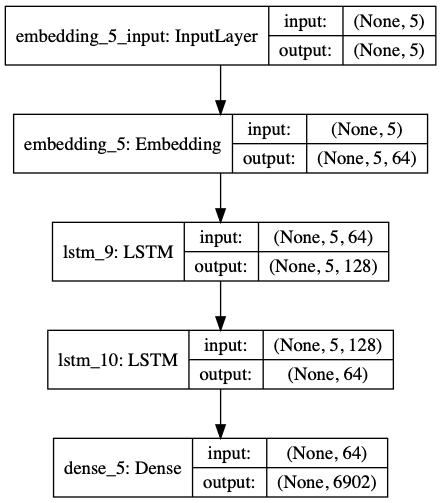

In [100]:
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

embed_dim = 64
model = Sequential()
model.add(Embedding(vocab_size,embed_dim,input_length=SEQUENCE_LENGTH-1))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(vocab_size, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])
plot_model(model, show_shapes=True)

In [101]:
fit = model.fit(predictors, label_cat, batch_size = 256, epochs=4, verbose=1)


/usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
902334/902334 [==============================] - 317s 351us/step - loss: 5.5938 - accuracy: 0.1581
Epoch 2/4
902334/902334 [==============================] - 350s 387us/step - loss: 5.4032 - accuracy: 0.1901
Epoch 3/4
902334/902334 [==============================] - 312s 345us/step - loss: 5.3361 - accuracy: 0.1968
Epoch 4/4
902334/902334 [==============================] - 322s 357us/step - loss: 5.3420 - accuracy: 0.1961


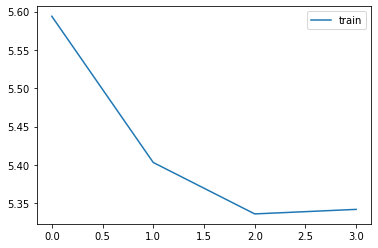

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(fit.history['loss'])
plt.legend(['train'])
plt.show()

In [104]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [108]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

def generate_text(nmax, text, temperature):
    n = 0
    tokens = tokenizer.tokenize(text)
    while (len(tokens) < nmax) :
        n +=1
        
        # only takes known words into account
        tokens_idx = [ vocab.index(word) if word in vocab else vocab.index('UNK') for word in tokens  ]
        # print(tokens_idx)
        tokens_list = pad_sequences([tokens_idx], maxlen=SEQUENCE_LENGTH-1, padding='pre')
        probas = model.predict_proba(tokens_list, verbose=0)[0]

        next_word_idx = sample(probas, temperature = temperature)
        next_word = vocab[next_word_idx]
        # print(next_word_idx, next_word)

        # next_word = np.random.choice(vocab, p = probas)
        if next_word != '?':
            print(next_word, probas[vocab.index(next_word)]  )
            text += ' ' + next_word
        # print(text)
        tokens = tokenizer.tokenize(text)
        if n> 200:
            break;
    return text

In [110]:
generate_text(15, 'a random variable', 3)

exceed 1.3802119e-05
f 0.0013476122
bit 1.1684407e-07
amoeba 1.2890748e-06
pairing 1.6996368e-07
i 0.041097082
affect 1.801226e-06
biomedcentral 5.0974744e-09
p 0.00017117262
customers 5.5763507e-05
the 0.050659794
fear 3.276233e-08


'a random variable exceed f bit amoeba pairing i affect biomedcentral p customers the fear'